In [27]:
# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
dataset = pd.read_csv('../dataset/baku_past5years_weather.csv')



In [16]:
# Función de mínimos cuadrados (la misma que teníamos antes)
def minimos_cuadrados_multiple(X, y):
    # Agregar columna de 1's para el intercepto
    X_with_ones = np.column_stack([np.ones(len(X)), X])
    
    # Calcular (X^T X)^(-1) X^T y
    X_transpose = X_with_ones.T
    XTX = np.dot(X_transpose, X_with_ones)
    XTX_inv = np.linalg.inv(XTX)
    XTy = np.dot(X_transpose, y)
    
    # Calcular los coeficientes (β)
    coeficientes = np.dot(XTX_inv, XTy)
    
    intercepto = coeficientes[0]
    pendientes = coeficientes[1:]
    
    return pendientes, intercepto

# Función para preparar datos temporales
def preparar_datos_temporales(df, dias_previos=3):
    """
    Prepara los datos para predecir la temperatura máxima usando los últimos n días
    """
    # Ordenar el dataset por fecha
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    
    X_temp = []
    y_temp = []
    
    # Para cada punto en el tiempo (excepto los primeros días_previos)
    for i in range(dias_previos, len(df)-1):
        # Tomar los datos de los últimos días_previos
        features = []
        for j in range(dias_previos):
            idx = i - j
            features.extend([
                float(df.iloc[idx]['maxtemp_C']),
                float(df.iloc[idx]['mintemp_C']),
                float(df.iloc[idx]['sunHour'])
            ])
        X_temp.append(features)
        # La variable a predecir es la temperatura máxima del día siguiente
        y_temp.append(float(df.iloc[i+1]['maxtemp_C']))
    
    return np.array(X_temp), np.array(y_temp)

# Preparar los datos
print("Preparando datos para el modelo temporal...")
X, y = preparar_datos_temporales(dataset)
print(f"Tamaño de los datos de entrenamiento: {len(X)} muestras")
print(f"Número de características por muestra: {X.shape[1]}")

# Entrenar el modelo
print("\nEntrenando el modelo...")
pendientes, intercepto = minimos_cuadrados_multiple(X, y)

# Función para hacer predicciones
def predecir_temp_maxima(datos_3dias):
    """
    Predice la temperatura máxima del día siguiente usando los datos de los últimos 3 días
    datos_3dias: lista de tuplas (maxtemp, mintemp, sunHour) para cada día
    """
    X_pred = []
    for dia in datos_3dias:
        X_pred.extend(dia)
    return intercepto + np.dot(pendientes, X_pred)

# Calcular métricas
def calcular_r2(y_real, y_predicho):
    media_y = np.mean(y_real)
    ss_tot = np.sum((y_real - media_y) ** 2)
    ss_res = np.sum((y_real - y_predicho) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

def calcular_mse(y_real, y_predicho):
    return np.mean((y_real - y_predicho) ** 2)

# Hacer predicciones y evaluar
print("\nEvaluando el modelo...")
y_pred = [predecir_temp_maxima([X[i][0:3], X[i][3:6], X[i][6:9]]) for i in range(len(X))]
r2 = calcular_r2(y, y_pred)
mse = calcular_mse(y, y_pred)
rmse = np.sqrt(mse)

print("\nResultados del modelo:")
print(f"R² (Coeficiente de determinación): {r2:.4f}")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}°C")


Preparando datos para el modelo temporal...
Tamaño de los datos de entrenamiento: 1822 muestras
Número de características por muestra: 9

Entrenando el modelo...

Evaluando el modelo...

Resultados del modelo:
R² (Coeficiente de determinación): 0.9309
Error Cuadrático Medio (MSE): 5.3574
Raíz del Error Cuadrático Medio (RMSE): 2.3146°C


In [17]:
# Mostrar ejemplos de predicción
print("\nEjemplos de predicciones:")

# Tomar 3 ejemplos aleatorios
for i in range(3):
    idx = np.random.randint(0, len(X))
    datos_reales = []
    print(f"\nPredicción {i+1}:")
    
    # Mostrar datos de los 3 días anteriores
    for j in range(3):
        start_idx = j * 3
        datos_dia = X[idx][start_idx:start_idx+3]
        datos_reales.append(datos_dia)
        fecha = dataset.iloc[idx-2+j]['date']
        print(f"\nDía {j+1} ({fecha}):")
        print(f"  - Temperatura máxima: {datos_dia[0]:.1f}°C")
        print(f"  - Temperatura mínima: {datos_dia[1]:.1f}°C")
        print(f"  - Horas de sol: {datos_dia[2]:.1f}")
    
    # Mostrar predicción y valor real
    pred = predecir_temp_maxima(datos_reales)
    fecha_prediccion = dataset.iloc[idx+1]['date']
    print(f"\nPara el día {fecha_prediccion}:")
    print(f"Temperatura máxima predicha: {pred:.1f}°C")
    print(f"Temperatura máxima real: {y[idx]:.1f}°C")
    print(f"Error: {abs(pred - y[idx]):.1f}°C")



Ejemplos de predicciones:

Predicción 1:

Día 1 (2023-05-14 00:00:00):
  - Temperatura máxima: 22.0°C
  - Temperatura mínima: 15.0°C
  - Horas de sol: 14.0

Día 2 (2023-05-15 00:00:00):
  - Temperatura máxima: 21.0°C
  - Temperatura mínima: 14.0°C
  - Horas de sol: 13.0

Día 3 (2023-05-16 00:00:00):
  - Temperatura máxima: 18.0°C
  - Temperatura mínima: 14.0°C
  - Horas de sol: 10.0

Para el día 2023-05-17 00:00:00:
Temperatura máxima predicha: 21.6°C
Temperatura máxima real: 22.0°C
Error: 0.4°C

Predicción 2:

Día 1 (2023-12-21 00:00:00):
  - Temperatura máxima: 14.0°C
  - Temperatura mínima: 7.0°C
  - Horas de sol: 9.0

Día 2 (2023-12-22 00:00:00):
  - Temperatura máxima: 9.0°C
  - Temperatura mínima: 5.0°C
  - Horas de sol: 9.0

Día 3 (2023-12-23 00:00:00):
  - Temperatura máxima: 15.0°C
  - Temperatura mínima: 7.0°C
  - Horas de sol: 9.0

Para el día 2023-12-24 00:00:00:
Temperatura máxima predicha: 14.0°C
Temperatura máxima real: 14.0°C
Error: 0.0°C

Predicción 3:

Día 1 (2023-10

In [ ]:
# Preparar los datos para predicción temporal
def preparar_datos_temporales(df, dias_previos=3):
    """
    Prepara los datos para predecir la temperatura máxima usando los últimos n días
    """
    X_temp = []
    y_temp = []
    
    # Para cada punto en el tiempo (excepto los primeros días_previos)
    for i in range(dias_previos, len(df)-1):
        # Tomar los datos de los últimos días_previos
        features = []
        for j in range(dias_previos):
            idx = i - j
            features.extend([
                df.iloc[idx]['maxtemp_C'],
                df.iloc[idx]['mintemp_C'],
                df.iloc[idx]['sunHour'],
                df.iloc[idx]['uvIndex']
            ])
        X_temp.append(features)
        # La variable a predecir es la temperatura máxima del día siguiente
        y_temp.append(df.iloc[i+1]['maxtemp_C'])
    
    return np.array(X_temp), np.array(y_temp)

# Preparar los datos para el modelo temporal
X, y = preparar_datos_temporales(dataset, dias_previos=3)
pendientes, intercepto = minimos_cuadrados_multiple(X, y)

def predecir_temp_maxima(datos_3dias):
    """
    Predice la temperatura máxima del día siguiente usando los datos de los últimos 3 días
    datos_3dias: lista de tuplas (maxtemp, mintemp, sunHour, uvIndex) para cada día
    """
    # Aplanar los datos de entrada
    X_pred = []
    for dia in datos_3dias:
        X_pred.extend(dia)
    
    # Hacer la predicción
    return intercepto + np.dot(pendientes, X_pred)

# Evaluar el modelo
y_pred = [predecir_temp_maxima([X[i][0:4], X[i][4:8], X[i][8:12]]) for i in range(len(X))]

# Calcular métricas
r2 = calcular_r2(y, y_pred)
mse = calcular_mse(y, y_pred)

print("Evaluación del modelo de predicción temporal:")
print(f"R² (Coeficiente de determinación): {r2:.4f}")
print(f"MSE (Error Cuadrático Medio): {mse:.4f}")
print(f"RMSE (Error Cuadrático Medio Raíz): {np.sqrt(mse):.4f}°C")

# Mostrar algunos ejemplos de predicción
print("\nEjemplos de predicciones:")
for i in range(3):
    idx = np.random.randint(0, len(X))
    datos_reales = []
    print(f"\nPredicción {i+1}:")
    
    # Mostrar datos de los 3 días anteriores
    for j in range(3):
        start_idx = j * 4
        datos_dia = X[idx][start_idx:start_idx+4]
        datos_reales.append(datos_dia)
        print(f"Día -{3-j}:")
        print(f"  - Temperatura máxima: {datos_dia[0]:.1f}°C")
        print(f"  - Temperatura mínima: {datos_dia[1]:.1f}°C")
        print(f"  - Horas de sol: {datos_dia[2]:.1f}")
        print(f"  - Índice UV: {datos_dia[3]:.1f}")
    
    # Mostrar predicción y valor real
    pred = predecir_temp_maxima(datos_reales)
    print(f"\nTemperatura máxima predicha para mañana: {pred:.1f}°C")
    print(f"Temperatura máxima real: {y[idx]:.1f}°C")
    print(f"Error: {abs(pred - y[idx]):.1f}°C")


Evaluación del modelo de predicción temporal:
R² (Coeficiente de determinación): 0.9314
MSE (Error Cuadrático Medio): 5.3220
RMSE (Error Cuadrático Medio Raíz): 2.3069°C

Ejemplos de predicciones:

Predicción 1:
Día -3:
  - Temperatura máxima: 28.0°C
  - Temperatura mínima: 21.0°C
  - Horas de sol: 15.0
  - Índice UV: 6.0
Día -2:
  - Temperatura máxima: 25.0°C
  - Temperatura mínima: 22.0°C
  - Horas de sol: 15.0
  - Índice UV: 6.0
Día -1:
  - Temperatura máxima: 25.0°C
  - Temperatura mínima: 21.0°C
  - Horas de sol: 15.0
  - Índice UV: 6.0

Temperatura máxima predicha para mañana: 27.6°C
Temperatura máxima real: 26.0°C
Error: 1.6°C

Predicción 2:
Día -3:
  - Temperatura máxima: 19.0°C
  - Temperatura mínima: 14.0°C
  - Horas de sol: 10.0
  - Índice UV: 5.0
Día -2:
  - Temperatura máxima: 18.0°C
  - Temperatura mínima: 11.0°C
  - Horas de sol: 10.0
  - Índice UV: 4.0
Día -1:
  - Temperatura máxima: 18.0°C
  - Temperatura mínima: 15.0°C
  - Horas de sol: 8.0
  - Índice UV: 4.0

Tempera

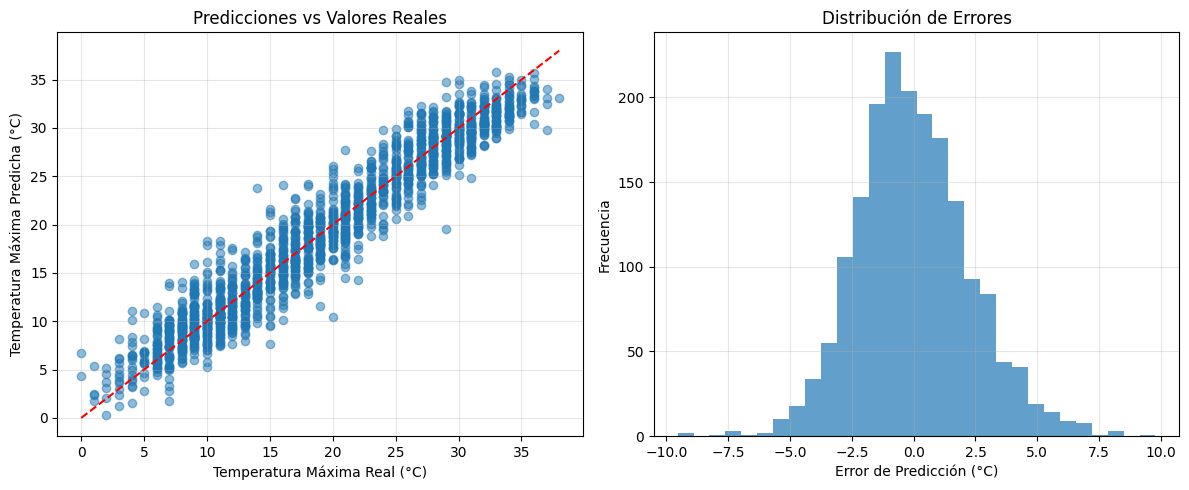


Estadísticas de los errores:
Error promedio: 0.00°C
Desviación estándar: 2.31°C
Error mínimo: -9.54°C
Error máximo: 9.78°C


In [28]:
# Visualizar predicciones vs valores reales
plt.figure(figsize=(12, 5))

# Graficar predicciones vs valores reales
plt.subplot(1, 2, 1)
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Predicción Perfecta')
plt.xlabel('Temperatura Máxima Real (°C)')
plt.ylabel('Temperatura Máxima Predicha (°C)')
plt.title('Predicciones vs Valores Reales')
plt.grid(True, alpha=0.3)

# Graficar histograma de errores
plt.subplot(1, 2, 2)
errores = np.array(y_pred) - np.array(y)
plt.hist(errores, bins=30, alpha=0.7)
plt.xlabel('Error de Predicción (°C)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar estadísticas de los errores
print("\nEstadísticas de los errores:")
print(f"Error promedio: {np.mean(errores):.2f}°C")
print(f"Desviación estándar: {np.std(errores):.2f}°C")
print(f"Error mínimo: {np.min(errores):.2f}°C")
print(f"Error máximo: {np.max(errores):.2f}°C")


{
    "Prediction": [
        {
            "temperature_Prediction": "predicted-Number",
            "estimated_weather": "conclusion by the model-String",
            "Explication": "conclusion by the model-String"
        }
   
    ]
}


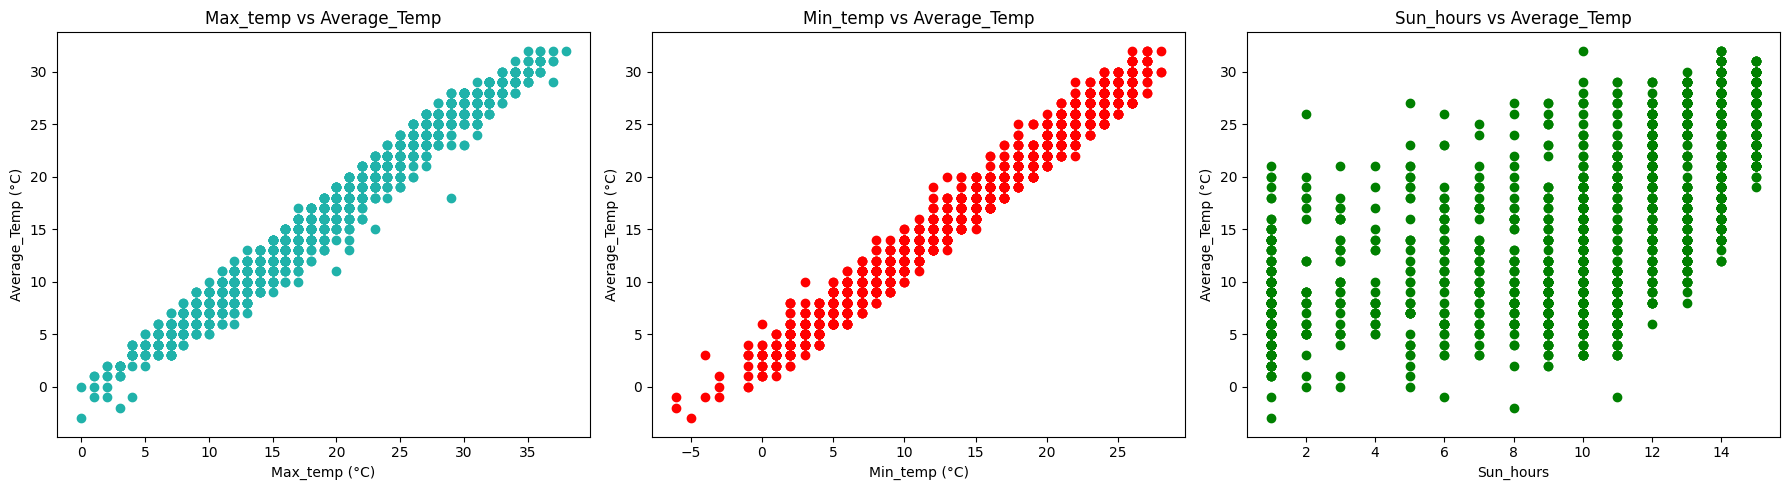

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Max_temp vs Average_Temp
axs[0].scatter(dataset['maxtemp_C'], dataset['avgtemp_C'], color='lightseagreen')
axs[0].set_title('Max_temp vs Average_Temp')
axs[0].set_xlabel('Max_temp (°C)')
axs[0].set_ylabel('Average_Temp (°C)')

# Gráfico 2: Min_temp vs Average_Temp
axs[1].scatter(dataset['mintemp_C'], dataset['avgtemp_C'], color='red')
axs[1].set_title('Min_temp vs Average_Temp')
axs[1].set_xlabel('Min_temp (°C)')
axs[1].set_ylabel('Average_Temp (°C)')

# Gráfico 3: Sun_hours vs Average_Temp
axs[2].scatter(dataset['sunHour'], dataset['avgtemp_C'], color='green')
axs[2].set_title('Sun_hours vs Average_Temp')
axs[2].set_xlabel('Sun_hours')
axs[2].set_ylabel('Average_Temp (°C)')

plt.tight_layout()
plt.show()

# Concluimos que la relacion si es lineal y aplicaremos una regresion lineal

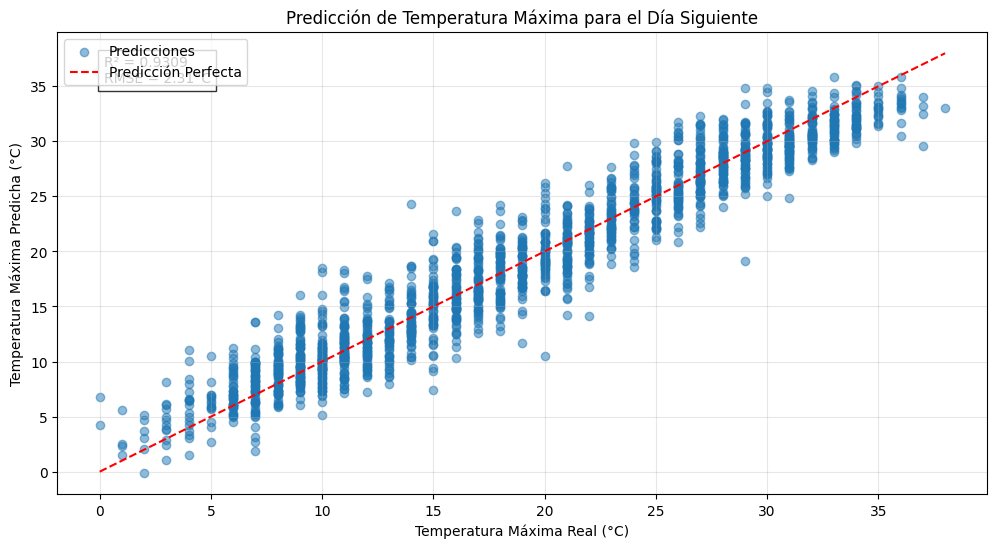

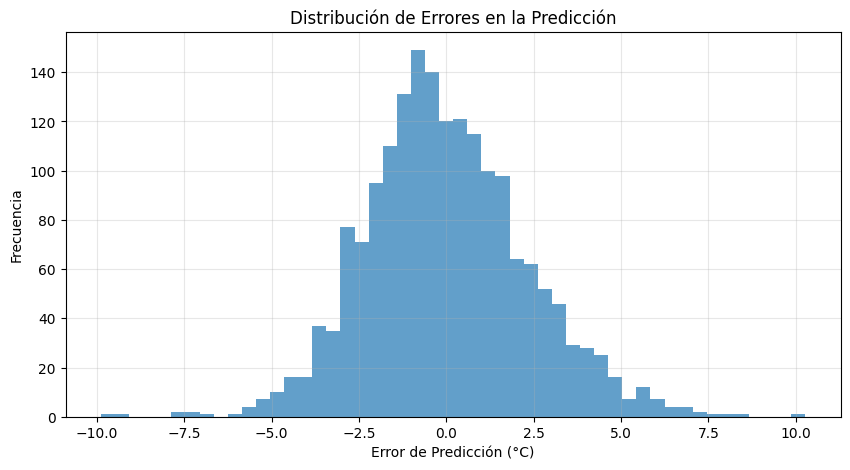

In [22]:
# Visualizar predicciones vs valores reales
plt.figure(figsize=(12, 6))

# Graficar predicciones vs valores reales
plt.scatter(y, y_pred, alpha=0.5, label='Predicciones')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Predicción Perfecta')

plt.xlabel('Temperatura Máxima Real (°C)')
plt.ylabel('Temperatura Máxima Predicha (°C)')
plt.title('Predicción de Temperatura Máxima para el Día Siguiente')

# Añadir texto con métricas
plt.text(0.05, 0.95, 
         f'R² = {r2:.4f}\nRMSE = {np.sqrt(mse):.2f}°C', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Graficar el histograma de errores
plt.figure(figsize=(10, 5))
errores = np.array(y_pred) - np.array(y)
plt.hist(errores, bins=50, alpha=0.7)
plt.xlabel('Error de Predicción (°C)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores en la Predicción')
plt.grid(True, alpha=0.3)
plt.show()


In [23]:
def minimos_cuadrados_multiple(X, y):
    # Agregar columna de 1's para el intercepto
    X_with_ones = np.column_stack([np.ones(len(X)), X])
    
    # Calcular (X^T X)^(-1) X^T y
    X_transpose = X_with_ones.T
    XTX = np.dot(X_transpose, X_with_ones)
    XTX_inv = np.linalg.inv(XTX)
    XTy = np.dot(X_transpose, y)
    
    # Calcular los coeficientes (β)
    coeficientes = np.dot(XTX_inv, XTy)
    
    intercepto = coeficientes[0]
    pendientes = coeficientes[1:]
    
    return pendientes, intercepto

# Preparar los datos incluyendo uvIndex
X = dataset[['maxtemp_C', 'mintemp_C', 'sunHour', 'uvIndex']].values
y = dataset['avgtemp_C'].values

pendientes, intercepto = minimos_cuadrados_multiple(X, y)


def modelo_rl_multiple(x1, x2, x3, x4):
    """
    Predice la temperatura promedio usando:
    x1: temperatura máxima
    x2: temperatura mínima
    x3: horas de sol
    x4: índice UV
    """
    return intercepto + pendientes[0] * x1 + pendientes[1] * x2 + pendientes[2] * x3 + pendientes[3] * x4

In [24]:
# 1. Hacer predicciones para todo el dataset
y_pred = [modelo_rl_multiple(x[0], x[1], x[2], x[3]) for x in X]

# 2. Calcular R² (coeficiente de determinación)
def calcular_r2(y_real, y_predicho):
    media_y = np.mean(y_real)
    ss_tot = np.sum((y_real - media_y) ** 2)
    ss_res = np.sum((y_real - y_predicho) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

# 3. Calcular MSE (Error Cuadrático Medio)
def calcular_mse(y_real, y_predicho):
    return np.mean((y_real - y_predicho) ** 2)

# Calcular y mostrar las métricas
r2 = calcular_r2(y, y_pred)
mse = calcular_mse(y, y_pred)

print("Evaluación del modelo:")
print(f"R² (Coeficiente de determinación): {r2:.4f}")
print(f"MSE (Error Cuadrático Medio): {mse:.4f}")
print("\nCoeficientes del modelo:")
print(f"Intercepto: {intercepto:.4f}")
print(f"Pendiente maxtemp_C: {pendientes[0]:.4f}")
print(f"Pendiente mintemp_C: {pendientes[1]:.4f}")
print(f"Pendiente sunHour: {pendientes[2]:.4f}")
print(f"Pendiente uvIndex: {pendientes[3]:.4f}")

# 4. Hacer algunas predicciones de ejemplo
print("\nEjemplos de predicciones:")
ejemplos = [
    (25, 15, 8, 6),   # día templado con UV moderado
    (35, 20, 12, 9),  # día caluroso con UV alto
    (15, 5, 6, 3)     # día frío con UV bajo
]

for temp_max, temp_min, horas_sol, uv in ejemplos:
    pred = modelo_rl_multiple(temp_max, temp_min, horas_sol, uv)
    print(f"\nPara:")
    print(f"  - Temperatura máxima: {temp_max}°C")
    print(f"  - Temperatura mínima: {temp_min}°C")
    print(f"  - Horas de sol: {horas_sol}")
    print(f"  - Índice UV: {uv}")
    print(f"Temperatura promedio predicha: {pred:.2f}°C")


Evaluación del modelo:
R² (Coeficiente de determinación): 0.9958
MSE (Error Cuadrático Medio): 0.2846

Coeficientes del modelo:
Intercepto: 0.0522
Pendiente maxtemp_C: 0.4699
Pendiente mintemp_C: 0.5130
Pendiente sunHour: -0.0168
Pendiente uvIndex: 0.0936

Ejemplos de predicciones:

Para:
  - Temperatura máxima: 25°C
  - Temperatura mínima: 15°C
  - Horas de sol: 8
  - Índice UV: 6
Temperatura promedio predicha: 19.92°C

Para:
  - Temperatura máxima: 35°C
  - Temperatura mínima: 20°C
  - Horas de sol: 12
  - Índice UV: 9
Temperatura promedio predicha: 27.40°C

Para:
  - Temperatura máxima: 15°C
  - Temperatura mínima: 5°C
  - Horas de sol: 6
  - Índice UV: 3
Temperatura promedio predicha: 9.85°C
